## An example of how to run XGBoost

### Step1. Install and Import

In [ ]:
# Install
#!pip install xgboost
#!pip install hyperopt

In [1]:
# Import packages
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder          
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [2]:
xgb.__version__

'1.5.0'

### Step2. Read data and do pre-processing

In [3]:
# Read data
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)
#Find how many rows and columns
data.shape

(891, 12)

In [4]:
#Summary of dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Check missing values
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Drop columns with too many missing values
data.drop('Cabin', axis=1, inplace=True)

In [7]:
# Inspect data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [8]:
# Transfrom attribute
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S


In [9]:
# Decide variables to use
X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']

In [10]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [11]:
# train/test split (80/20)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)
x_train.shape , x_test.shape

((712, 6), (179, 6))

### Step4. Run XGBoost with Hyperparameter tunining

#### Bayesian Optimization implementation 
To build more robust models with XGBoost, we should always perform k-fold cross validation.
- booster[default = gbtree]
- eta [default=0.3, alias: learning_rate]
- gamma [default=0, alias: min_split_loss]
- max_depth [default=6]
- min_child_weight [default=1]
- max_delta_step [default=0]
- subsample [default=1]
- colsample_bytree, colsample_bylevel, colsample_bynode [default=1]
- lambda [default=1, alias: reg_lambda]
- alpha [default=0, alias: reg_alpha]
- scale_pos_weight [default=1]

- HYPEROPT is a powerful python library that search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.

- Bayesian Optimization technique uses Hyperopt to tune the model hyperparameters. Hyperopt is a Python library which is used to tune model hyperparameters.



In [23]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [29]:
def objective(space):
    clf=xgb.XGBClassifier(use_label_encoder=False,
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [30]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                      

0.7877094972067039                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.7486033519553073                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.6368715083798883                                                              
SCORE:                                                                          
0.770949720670391                                                               
SCORE:                                                                          
0.6368715083798883          

- Here best_hyperparams gives us the optimal parameters that best fit model and better loss function value.

- trials is an object that contains or stores all the relevant information such as hyperparameter, loss-functions for each set of parameters that the model has been trained.

- ‘fmin’ is an optimization function that minimizes the loss function and takes in 4 inputs - fn, space, algo and max_evals.



In [31]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5370349918217041, 'gamma': 5.608870758199104, 'max_depth': 15.0, 'min_child_weight': 7.0, 'reg_alpha': 48.0, 'reg_lambda': 0.3036158352299454}


### Step6. Run XGBoost with the tuned parameter

In [32]:
# declare parameters
params = {
            'objective':'binary:logistic',
            'n_estimators':100,
            'eval_metric':'logloss',
            'use_label_encoder':False
        }         
params.update(best_hyperparams)

# changing datatypes for integer hyper parameters
int_hp = ["max_depth"]
for h in int_hp:
    params[h] = int(params[h])

# instantiate the classifier 
xgb_best = xgb.XGBClassifier(**params)


# fit the classifier to the training data
xgb_best.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5370349918217041,
              enable_categorical=False, eval_metric='logloss',
              gamma=5.608870758199104, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=15, min_child_weight=7.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=48.0, reg_lambda=0.3036158352299454, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [33]:
# we can view the parameters of the xgb trained model as follows -

print(xgb_best)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5370349918217041,
              enable_categorical=False, eval_metric='logloss',
              gamma=5.608870758199104, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=15, min_child_weight=7.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=48.0, reg_lambda=0.3036158352299454, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


### Step6. Make predictions with XGBoost Classifier

In [34]:
# make predictions on test data
y_pred = xgb_best.predict(x_test)
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0])

### Step7. Check Accuracy

In [35]:
# compute and print accuracy score

from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


XGBoost model accuracy score: 0.7989


### Step8. Feature importance with XGBoost
XGBoost provides a way to examine the importance of each feature in the original dataset within the model.
It involves counting the number of times each feature is split on across all boosting trees in the model.

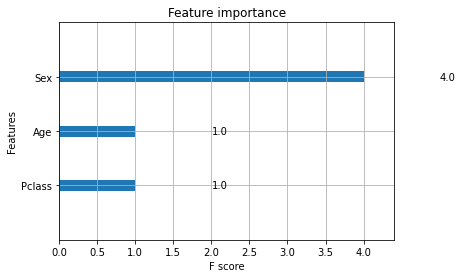

<Figure size 1152x864 with 0 Axes>

In [36]:
xgb.plot_importance(xgb_best)
plt.figure(figsize = (16, 12))
plt.show()